# Simple RNN Encode-Decoder for Translation

**Learning Objectives**
1. Learn how to create a tf.data.Dataset for seq2seq problems
1. Learn how to train an encoder-decoder model in Keras
1. Learn how to save the encoder and the decoder as separate models 
1. Learn how to piece together the trained encoder and decoder into a translation function
1. Learn how to use the BLUE score to evaluate a translation model

## Introduction

In this lab we'll build a translation model from Spanish to English using a RNN encoder-decoder model architecture.
We will start by creating train and eval datasets (using the `tf.data.Dataset` API) that are typical for seq2seq problems. Then we will use the Keras functional API to train an RNN encoder-decoder model, which will save as two separate models, the encoder and decoder model. Using these two separate pieces we will implement the translation function.
At last, we'll benchmark our results using the industry standard BLEU score.

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
import pickle
import sys

import evaluate
import numpy as np
import pandas as pd
import tensorflow as tf
import utils_preproc
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GRU, Dense, Embedding, Input
from tensorflow.keras.models import Model, load_model
from tqdm import tqdm

print(tf.__version__)

2.12.0


In [3]:
SEED = 0
MODEL_PATH = "translate_models/baseline"
DATA_URL = (
    "http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
)
LOAD_CHECKPOINT = False

In [4]:
tf.random.set_seed(SEED)

## Downloading the Data

We'll use a language dataset provided by http://www.manythings.org/anki/. The dataset contains Spanish-English  translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

The dataset is a curated list of 120K translation pairs from http://tatoeba.org/, a platform for community contributed translations by native speakers.

In [5]:
path_to_zip = tf.keras.utils.get_file(
    "spa-eng.zip", origin=DATA_URL, extract=True
)

path_to_file = os.path.join(os.path.dirname(path_to_zip), "spa-eng/spa.txt")
print("Translation data stored at:", path_to_file)

Translation data stored at: /home/jupyter/.keras/datasets/spa-eng/spa.txt


In [6]:
data = pd.read_csv(
    path_to_file, sep="\t", header=None, names=["english", "spanish"]
)

In [7]:
data.sample(3)

,english,spanish
22178,Tom won't last long.,Tom no durará mucho.
11257,My mother is out.,Mi madre ha salido.
41450,She carried a silk purse.,Llevaba una bolsa de seda.


From the `utils_preproc` package we have written for you,
we will use the following functions to pre-process our dataset of sentence pairs.

## Sentence Preprocessing

The `utils_preproc.preprocess_sentence()` method does the following:
1. Converts sentence to lower case
2. Adds a space between punctuation and words
3. Replaces tokens that aren't a-z or punctuation with space
4. Adds `<start>` and `<end>` tokens

For example:

In [8]:
raw = [
    "No estamos comiendo.",
    "Está llegando el invierno.",
    "El invierno se acerca.",
    "Tom no comio nada.",
    "Su pierna mala le impidió ganar la carrera.",
    "Su respuesta es erronea.",
    "¿Qué tal si damos un paseo después del almuerzo?",
]

In [9]:
processed = [utils_preproc.preprocess_sentence(s) for s in raw]
processed

['<start> no estamos comiendo . <end>',
 '<start> esta llegando el invierno . <end>',
 '<start> el invierno se acerca . <end>',
 '<start> tom no comio nada . <end>',
 '<start> su pierna mala le impidio ganar la carrera . <end>',
 '<start> su respuesta es erronea . <end>',
 '<start> ¿ que tal si damos un paseo despues del almuerzo ? <end>']

## Sentence Integerizing

The `utils_preproc.tokenize()` method does the following:
    
1. Splits each sentence into a token list
1. Maps each token to an integer
1. Pads to length of longest sentence 

It returns an instance of a [Keras Tokenizer](https://keras.io/preprocessing/text/)
containing the token-integer mapping along with the integerized sentences:

In [10]:
integerized, tokenizer = utils_preproc.tokenize(processed)
integerized

array([[ 1,  4,  8,  9,  3,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 10, 11,  5,  6,  3,  2,  0,  0,  0,  0,  0,  0],
       [ 1,  5,  6, 12, 13,  3,  2,  0,  0,  0,  0,  0,  0],
       [ 1, 14,  4, 15, 16,  3,  2,  0,  0,  0,  0,  0,  0],
       [ 1,  7, 17, 18, 19, 20, 21, 22, 23,  3,  2,  0,  0],
       [ 1,  7, 24, 25, 26,  3,  2,  0,  0,  0,  0,  0,  0],
       [ 1, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,  2]], dtype=int32)

The outputted tokenizer can be used to get back the actual works
from the integers representing them:

In [11]:
tokenizer.sequences_to_texts(integerized)

['<start> no estamos comiendo . <end>',
 '<start> esta llegando el invierno . <end>',
 '<start> el invierno se acerca . <end>',
 '<start> tom no comio nada . <end>',
 '<start> su pierna mala le impidio ganar la carrera . <end>',
 '<start> su respuesta es erronea . <end>',
 '<start> ¿ que tal si damos un paseo despues del almuerzo ? <end>']

## Creating the tf.data.Dataset

### `load_and_preprocess`

Let's first implement a function that will read the raw sentence-pair file
and preprocess the sentences with `utils_preproc.preprocess_sentence`.

The `load_and_preprocess` function takes as input
- the path where the sentence-pair file is located
- the number of examples one wants to read in

It returns a tuple whose first component contains the english
preprocessed sentences, while the second component contains the
spanish ones:

In [8]:
def load_and_preprocess(path, num_examples):
    with open(path_to_file) as fp:
        lines = fp.read().strip().split("\n")

    # TODO 1a
    sentence_pairs = [
        [utils_preproc.preprocess_sentence(sent) for sent in line.split("\t")]
        for line in lines[:num_examples]
    ]

    return zip(*sentence_pairs)

In [9]:
en, sp = load_and_preprocess(path_to_file, num_examples=10)

print(en[-1])
print(sp[-1])

<start> fire ! <end>
<start> incendio ! <end>


### `load_and_integerize`

Using `utils_preproc.tokenize`, let us now implement the function `load_and_integerize` that takes as input the data path along with the number of examples we want to read in and returns the following tuple:

```python
  (input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer)
```

where 


* `input_tensor` is an integer tensor of shape `(num_examples, max_length_inp)` containing the integerized versions of the source language sentences
* `target_tensor` is an integer tensor of shape `(num_examples, max_length_targ)` containing the integerized versions of the target language sentences
* `inp_lang_tokenizer` is the source language tokenizer
* `targ_lang_tokenizer` is the target language tokenizer

In [10]:
def load_and_integerize(path, num_examples=None):
    targ_lang, inp_lang = load_and_preprocess(path, num_examples)

    # TODO 1b
    input_tensor, inp_lang_tokenizer = utils_preproc.tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = utils_preproc.tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Train and eval splits

We'll split this data 80/20 into train and validation, and we'll use only the first 30K examples, since we'll be training on a single GPU. 
 
Let us set variable for that:

In [12]:
TEST_PROP = 0.2
NUM_EXAMPLES = 300000

Now let's load and integerize the sentence paris and store the tokenizer for the source and the target language into the `int_lang` and `targ_lang` variable respectively:

In [13]:
input_tensor, target_tensor, inp_lang, targ_lang = load_and_integerize(
    path_to_file, NUM_EXAMPLES
)

Let us store the maximal sentence length of both languages into two variables:

In [14]:
max_length_targ = target_tensor.shape[1]
max_length_inp = input_tensor.shape[1]

We are now using scikit-learn `train_test_split` to create our splits:

In [15]:
splits = train_test_split(
    input_tensor, target_tensor, test_size=TEST_PROP, random_state=SEED
)

input_tensor_train = splits[0]
input_tensor_val = splits[1]

target_tensor_train = splits[2]
target_tensor_val = splits[3]

Let's make sure the number of example in each split looks good:

In [16]:
(
    len(input_tensor_train),
    len(target_tensor_train),
    len(input_tensor_val),
    len(target_tensor_val),
)

(95171, 95171, 23793, 23793)

The `utils_preproc.int2word` function allows you to transform back the integerized sentences into words. Note that the `<start>` token is alwasy encoded as `1`, while the `<end>` token is always encoded as `0`:

In [17]:
print("Input Language; int to word mapping")
print(input_tensor_train[0])
print(utils_preproc.int2word(inp_lang, input_tensor_train[0]), "\n")

print("Target Language; int to word mapping")
print(target_tensor_train[0])
print(utils_preproc.int2word(targ_lang, target_tensor_train[0]))

Input Language; int to word mapping
[  1   9 838   7  31   7  10 173   3   2   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
['<start>', 'tom', 'siguio', 'a', 'mary', 'a', 'la', 'habitacion', '.', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''] 

Target Language; int to word mapping
[   1    8 1342   32  184    5  141    3    2    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
['<start>', 'tom', 'followed', 'mary', 'into', 'the', 'room', '.', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 

### Create tf.data dataset for train and eval

Below we implement the `create_dataset` function that takes as input
* `encoder_input` which is an integer tensor of shape `(num_examples, max_length_inp)` containing the integerized versions of the source language sentences
* `decoder_input` which is an integer tensor of shape `(num_examples, max_length_targ)`containing the integerized versions of the target language sentences

It returns a `tf.data.Dataset` containing examples for the form

```python
        ((source_sentence, target_sentence), shifted_target_sentence)
```

where `source_sentence` and `target_setence` are the integer version of source-target language pairs and `shifted_target` is the same as `target_sentence` but with indices shifted by 1. 

**Remark:** In the training code, `source_sentence`  (resp. `target_sentence`) will be fed as the encoder (resp. decoder) input, while `shifted_target` will be used to compute the cross-entropy loss by comparing the decoder output with the shifted target sentences. 

In [18]:
def create_dataset(encoder_input, decoder_input):
    # TODO 1c

    # shift ahead by 1
    target = tf.roll(decoder_input, -1, 1)

    # replace last column with 0s
    zeros = tf.zeros([target.shape[0], 1], dtype=tf.int32)
    target = tf.concat((target[:, :-1], zeros), axis=-1)

    dataset = tf.data.Dataset.from_tensor_slices(
        ((encoder_input, decoder_input), target)
    )

    return dataset

Let's now create the actual train and eval dataset using the function above:

In [19]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64

In [41]:
train_dataset = (
    create_dataset(input_tensor_train, target_tensor_train)
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(BATCH_SIZE, drop_remainder=True)
)


eval_dataset = create_dataset(input_tensor_val, target_tensor_val).batch(
    BATCH_SIZE, drop_remainder=True
)

In [42]:
for d in train_dataset:
    print(d[0][1])
    print(d[1])
    break

tf.Tensor(
[[   1   75    6   36  203  546    7    2    0    0    0]
 [   1    5   11    9 3332    3    2    0    0    0    0]
 [   1    4 2204  420   21  134    3    2    0    0    0]
 [   1    5   95   13 2389    3    2    0    0    0    0]
 [   1    6  230   17    3    2    0    0    0    0    0]
 [   1   52   22    6   47  126    7    2    0    0    0]
 [   1    4   38 4131   10  284    3    2    0    0    0]
 [   1   72    6  131    3    2    0    0    0    0    0]
 [   1    9  579  853   68   50    3    2    0    0    0]
 [   1   39  543   15   36    7    2    0    0    0    0]
 [   1   14 1003   61  407    3    2    0    0    0    0]
 [   1   19  678   66 1868    3    2    0    0    0    0]
 [   1   36  170   37    2    0    0    0    0    0    0]
 [   1   16   35   41    3    2    0    0    0    0    0]
 [   1    4   93   74    3    2    0    0    0    0    0]
 [   1    4   70   76   13  407    3    2    0    0    0]
 [   1   14   11    9  289  559    3    2    0    0    0]
 [ 

## Training the RNN encoder-decoder model

We use an encoder-decoder architecture, however we embed our words into a latent space prior to feeding them into the RNN. 

In [52]:
EMBEDDING_DIM = 256
HIDDEN_UNITS = 1024

INPUT_VOCAB_SIZE = len(inp_lang.word_index) + 1
TARGET_VOCAB_SIZE = len(targ_lang.word_index) + 1

Let's implement the encoder network with Keras functional API. It will
* start with an `Input` layer that will consume the source language integerized sentences
* then feed them to an `Embedding` layer of `EMBEDDING_DIM` dimensions
* which in turn will pass the embeddings to a `GRU` recurrent layer with `HIDDEN_UNITS`

The output of the encoder will be the `encoder_outputs` and the `encoder_state`. 

In [55]:
encoder_inputs = Input(shape=(None,), name="encoder_input")

# TODO 2a
encoder_inputs_embedded = Embedding(
    input_dim=INPUT_VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    input_length=max_length_inp,
)(encoder_inputs)

# hiddon_sequeses = GRU(
#     units=HIDDEN_UNITS,
#     return_sequences=True,
#     recurrent_initializer="glorot_uniform",
# )(encoder_inputs_embedded)

# # hiddon_sequeses = GRU(
# #     units=HIDDEN_UNITS,
# #     return_sequences=True,
# #     recurrent_initializer="glorot_uniform",
# # )(hiddon_sequeses)

# encoder_outputs, encoder_state = GRU(
#     units=HIDDEN_UNITS,
#     return_sequences=True,
#     return_state=True,
#     recurrent_initializer="glorot_uniform",
# )(hiddon_sequeses)


encoder_outputs, encoder_state = GRU(
    units=HIDDEN_UNITS,
    dropout=0.3,
    return_sequences=True,
    return_state=True,
    recurrent_initializer="glorot_uniform",
)(encoder_inputs_embedded)

We now implement the decoder network, which is very similar to the encoder network.

It will
* start with an `Input` layer that will consume the source language integerized sentences
* then feed that input to an `Embedding` layer of `EMBEDDING_DIM` dimensions
* which in turn will pass the embeddings to a `GRU` recurrent layer with `HIDDEN_UNITS`

**Important:** The main difference with the encoder, is that the recurrent `GRU` layer will take as input not only the decoder input embeddings, but also the `encoder_state` as outputted by the encoder above. This is where the two networks are linked!

The output of the encoder will be the `decoder_outputs` and the `decoder_state`. 

In [56]:
decoder_inputs = Input(shape=(None,), name="decoder_input")

# TODO 2b
decoder_inputs_embedded = Embedding(
    input_dim=TARGET_VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    input_length=max_length_targ,
)(decoder_inputs)

decoder_rnn = GRU(
    units=HIDDEN_UNITS,
    return_sequences=True,
    return_state=True,
    recurrent_initializer="glorot_uniform",
)

decoder_outputs, decoder_state = decoder_rnn(
    decoder_inputs_embedded, initial_state=encoder_state
)

The last part of the encoder-decoder architecture is a softmax `Dense` layer that will create the next word probability vector or next word `predictions` from the `decoder_output`:

In [57]:
decoder_dense = Dense(TARGET_VOCAB_SIZE, activation="softmax")

predictions = decoder_dense(decoder_outputs)

To be able to train the encoder-decoder network defined above, we now need to create a trainable Keras `Model` by specifying which are the `inputs` and the `outputs` of our problem. They should correspond exactly to what the type of input/output in our train and eval `tf.data.Dataset` since that's what will be fed to the `inputs` and `outputs` we declare while instantiating the Keras `Model`.

While compiling our model, we should make sure that the loss is the `sparse_categorical_crossentropy` so that we can compare the true word indices for the target language as outputted by our train `tf.data.Dataset` with the next word `predictions` vector as outputted by the decoder:

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, None, 256)    2409984     ['encoder_input[0][0]']          
                                                                                                  
 embedding_11 (Embedding)       (None, None, 256)    1263360     ['decoder_input[0][0]']          
                                                                                            

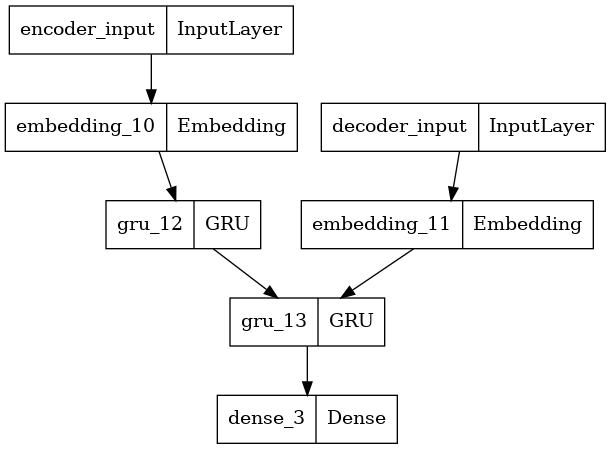

In [58]:
# TODO 2c
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=predictions)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
model.summary()
tf.keras.utils.plot_model(model)

Let's now train the model!

Epoch 1/30
375/375 [==============================] - 20s 45ms/step - loss: 2.0756 - val_loss: 1.5919
Epoch 2/30
375/375 [==============================] - 11s 29ms/step - loss: 1.3690 - val_loss: 1.2781
Epoch 3/30
375/375 [==============================] - 11s 28ms/step - loss: 1.0313 - val_loss: 1.0707
Epoch 4/30
375/375 [==============================] - 11s 28ms/step - loss: 0.7637 - val_loss: 0.9590
Epoch 5/30
375/375 [==============================] - 10s 28ms/step - loss: 0.5513 - val_loss: 0.8921
Epoch 6/30
375/375 [==============================] - 11s 29ms/step - loss: 0.3857 - val_loss: 0.8500
Epoch 7/30
375/375 [==============================] - 10s 28ms/step - loss: 0.2661 - val_loss: 0.8445
Epoch 8/30
375/375 [==============================] - 11s 28ms/step - loss: 0.1853 - val_loss: 0.8507
Epoch 9/30
375/375 [==============================] - 11s 28ms/step - loss: 0.1348 - val_loss: 0.8665
Epoch 10/30
375/375 [==============================] - 11s 29ms/step - loss: 0.103

<Axes: >

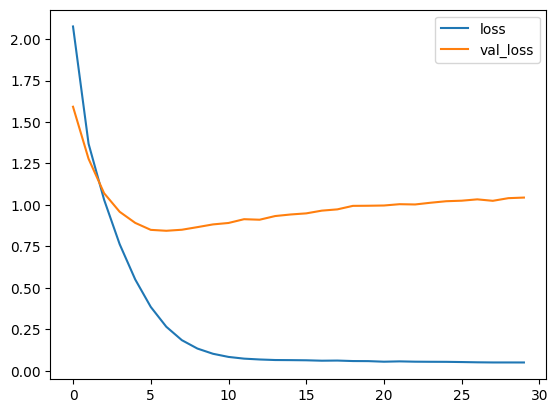

In [59]:
STEPS_PER_EPOCH = len(input_tensor_train) // BATCH_SIZE
EPOCHS = 30


history = model.fit(
    train_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=eval_dataset,
    epochs=EPOCHS,
)

pd.DataFrame(history.history)[["loss", "val_loss"]].plot()

## Implementing the translation (or decoding) function

We can't just use model(), because we don't know all the inputs we used during training. We only know the encoder_input (source language) but not the decoder_input (target language), which is what we want to predict (i.e., the translation of the source language)!

We do however know the first token of the decoder input, which is the `<start>` token. So using this plus the state of the encoder RNN, we can predict the next token. We will then use that token to be the second token of decoder input, and continue like this until we predict the `<end>` token, or we reach some defined max length.

So, the strategy now is to split our trained network into two independent Keras models:

* an **encoder model** with signature `encoder_inputs -> encoder_state`
* a **decoder model** with signature `[decoder_inputs, decoder_state_input] -> [predictions, decoder_state]`

This way, we will be able to encode the source language sentence into the vector `encoder_state` using the encoder and feed it to the decoder model along with the `<start>` token at step 1. 

Given that input, the decoder will produce the first word of the translation, by sampling from the `predictions` vector (for simplicity, our sampling strategy here will be to take the next word to be the one whose index has the maximum probability in the `predictions` vector) along with a new state vector, the `decoder_state`. 

At this point, we can feed again to the decoder the predicted first word and as well as the new `decoder_state` to predict the translation second word. 

This process can be continued until the decoder produces the token `<stop>`. 

This is how we will implement our translation (or decoding) function, but let us first extract a separate encoder and a separate decoder from our trained encoder-decoder model. 


**Remark:** If we have already trained and saved the models (i.e, `LOAD_CHECKPOINT` is `True`) we will just load the models, otherwise, we extract them from the trained network above by explicitly creating the encoder and decoder Keras `Model`s with the signature we want.



In [60]:
if LOAD_CHECKPOINT:
    encoder_model = load_model(os.path.join(MODEL_PATH, "encoder_model"))
    decoder_model = load_model(os.path.join(MODEL_PATH, "decoder_model"))

else:
    # TODO 3a
    encoder_model = Model(inputs=encoder_inputs, outputs=encoder_state)

    decoder_state_input = Input(
        shape=(HIDDEN_UNITS,), name="decoder_state_input"
    )

    # Reuses weights from the decoder_rnn layer
    decoder_outputs, decoder_state = decoder_rnn(
        decoder_inputs_embedded, initial_state=decoder_state_input
    )

    # Reuses weights from the decoder_dense layer
    predictions = decoder_dense(decoder_outputs)

    decoder_model = Model(
        inputs=[decoder_inputs, decoder_state_input],
        outputs=[predictions, decoder_state],
    )

Now that we have a separate encoder and a separate decoder, let's implement a translation function, to which we will give the generic name of `decode_sequences` (to stress that this procedure is general to all seq2seq problems). 

`decode_sequences` will take as input
* `input_seqs` which is the integerized source language sentence tensor that the encoder can consume
* `output_tokenizer` which is the target languague tokenizer we will need to extract back words from predicted word integers
* `max_decode_length` which is the length after which we stop decoding if the `<stop>` token has not been predicted


**Note**: Now that the encoder and decoder have been turned into Keras models, to feed them their input, we need to use the `.predict` method.

In [61]:
def decode_sequences(input_seqs, output_tokenizer, max_decode_length=50):
    """
    Arguments:
    input_seqs: int tensor of shape (BATCH_SIZE, SEQ_LEN)
    output_tokenizer: Tokenizer used to conver from int to words

    Returns translated sentences
    """
    # Encode the input as state vectors.
    states_value = encoder_model(input_seqs)

    # Populate the first character of target sequence with the start character.
    batch_size = input_seqs.shape[0]
    target_seq = tf.ones([batch_size, 1])

    decoded_sentences = [[] for _ in range(batch_size)]

    # TODO 4: Sampling loop
    for i in range(max_decode_length):
        output_tokens, decoder_state = decoder_model([target_seq, states_value])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[:, -1, :], axis=-1)

        tokens = utils_preproc.int2word(output_tokenizer, sampled_token_index)

        for j in range(batch_size):
            decoded_sentences[j].append(tokens[j])

        # Update the target sequence (of length 1).
        target_seq = tf.expand_dims(tf.constant(sampled_token_index), axis=-1)

        # Update states
        states_value = decoder_state

    return decoded_sentences

Now we're ready to predict!

In [62]:
sentences = [
    "No estamos comiendo.",
    "Está llegando el invierno.",
    "El invierno se acerca.",
    "Tom no comio nada.",
    "Su pierna mala le impidió ganar la carrera.",
    "Su respuesta es erronea.",
    "¿Qué tal si damos un paseo después del almuerzo?",
]

reference_translations = [
    "We're not eating.",
    "Winter is coming.",
    "Winter is coming.",
    "Tom ate nothing.",
    "His bad leg prevented him from winning the race.",
    "Your answer is wrong.",
    "How about going for a walk after lunch?",
]

machine_translations = decode_sequences(
    utils_preproc.preprocess(sentences, inp_lang), targ_lang, max_length_targ
)

for i in range(len(sentences)):
    print("-")
    print("INPUT:")
    print(sentences[i])
    print("REFERENCE TRANSLATION:")
    print(reference_translations[i])
    print("MACHINE TRANSLATION:")
    print(machine_translations[i])

-
INPUT:
No estamos comiendo.
REFERENCE TRANSLATION:
We're not eating.
MACHINE TRANSLATION:
['we', 're', 'not', 'eating', '.', '<end>', '', '', '', '', '']
-
INPUT:
Está llegando el invierno.
REFERENCE TRANSLATION:
Winter is coming.
MACHINE TRANSLATION:
['winter', 'is', 'coming', '.', '<end>', '', '', '', '', '', '']
-
INPUT:
El invierno se acerca.
REFERENCE TRANSLATION:
Winter is coming.
MACHINE TRANSLATION:
['winter', 'is', 'coming', '.', '<end>', '', '', '', '', '', '']
-
INPUT:
Tom no comio nada.
REFERENCE TRANSLATION:
Tom ate nothing.
MACHINE TRANSLATION:
['tom', 'ate', 'nothing', '.', '<end>', '', '', '', '', '', '']
-
INPUT:
Su pierna mala le impidió ganar la carrera.
REFERENCE TRANSLATION:
His bad leg prevented him from winning the race.
MACHINE TRANSLATION:
['his', 'word', 'is', 'other', '.', '<end>', '', '', '', '', '']
-
INPUT:
Su respuesta es erronea.
REFERENCE TRANSLATION:
Your answer is wrong.
MACHINE TRANSLATION:
['your', 'shirt', 'is', 'orange', '.', '<end>', '', '', ''

### Checkpoint Model

Now let's us save the full training encoder-decoder model, as well as the separate encoder and decoder model to disk for latter reuse:

In [ ]:
if not LOAD_CHECKPOINT:
    os.makedirs(MODEL_PATH, exist_ok=True)

    # TODO 3b
    model.save(os.path.join(MODEL_PATH, "model"))
    encoder_model.save(os.path.join(MODEL_PATH, "encoder_model"))
    decoder_model.save(os.path.join(MODEL_PATH, "decoder_model"))

    with open(os.path.join(MODEL_PATH, "encoder_tokenizer.pkl"), "wb") as fp:
        pickle.dump(inp_lang, fp)

    with open(os.path.join(MODEL_PATH, "decoder_tokenizer.pkl"), "wb") as fp:
        pickle.dump(targ_lang, fp)

## Evaluation Metric (BLEU)

Unlike say, image classification, there is no one right answer for a machine translation. However our current loss metric, cross entropy, only gives credit when the machine translation matches the exact same word in the same order as the reference translation. 

Many attempts have been made to develop a better metric for natural language evaluation. The most popular currently is Bilingual Evaluation Understudy (BLEU).

- It is quick and inexpensive to calculate.
- It allows flexibility for the ordering of words and phrases.
- It is easy to understand.
- It is language independent.
- It correlates highly with human evaluation.
- It has been widely adopted.

The score is from 0 to 1, where 1 is an exact match.

It works by counting matching n-grams between the machine and reference texts, regardless of order. BLUE-4 counts matching n grams from 1-4 (1-gram, 2-gram, 3-gram and 4-gram). It is common to report both BLUE-1 and BLUE-4

It still is imperfect, since it gives no credit to synonyms and so human evaluation is still best when feasible. However BLEU is commonly considered the best among bad options for an automated metric.

The Hugging Face evaluate framework has an implementation that we will use.

We can't run calculate BLEU during training, because at that time the correct decoder input is used. Instead we'll calculate it now.

For more info: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

In [ ]:
def postprocess(sentence):
    filtered = list(filter(lambda x: x != "" and x != "<end>", sentence))
    return " ".join(filtered)

Let's now average the `bleu_1` and `bleu_4` scores for all the sentence pairs in the eval set. The next cell takes around 1 minute (8 minutes for full dataset eval) to run, the bulk of which is decoding the sentences in the validation set. Please wait until completes.

In [ ]:
NUM_EVALUATE = 1000  # `len(input_tensor_val)` for full eval.

reference = []
candidate = []

for idx in tqdm(range(NUM_EVALUATE)):
    reference_sentence = utils_preproc.int2word(
        targ_lang, target_tensor_val[idx][1:]
    )

    decoded_sentence = decode_sequences(
        input_tensor_val[idx : idx + 1], targ_lang, max_length_targ
    )[0]

    candidate.append(postprocess(decoded_sentence))
    reference.append([postprocess(reference_sentence)])

### Check the score

In [ ]:
bleu = evaluate.load("bleu")
bleu_1 = bleu.compute(predictions=candidate, references=reference, max_order=1)
bleu_4 = bleu.compute(predictions=candidate, references=reference, max_order=4)

In [ ]:
bleu_1["bleu"]

In [ ]:
bleu_4["bleu"]

### References

- Francois Chollet: https://github.com/keras-team/keras-io/blob/master/examples/nlp/lstm_seq2seq.py
